In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333 and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [00:06<00:00, 1753.53it/s]


10391

In [2]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10391, (90948,))

In [21]:
print(max_length)

90948


In [3]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
standard = StandardScaler()
adjusted_recordings = standard.fit_transform(adjusted_recordings)
print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




[[-3.91315894e-03 -2.08178719e-03  7.07403015e-03 ...  3.97710492e-02
   3.89222529e-02  3.43722279e-02]
 [ 2.54340067e-01  3.18888249e-01  5.00963191e-01 ... -3.15180136e-01
  -2.67018609e-01 -1.80737937e-01]
 [-1.11767359e-03 -2.09454250e-03 -2.72278684e-04 ...  1.59298169e-02
   9.39241865e-03 -2.23828698e-03]
 ...
 [ 2.27792832e-01  2.35611148e-01  2.11838498e-01 ...  6.82101747e-02
   5.28060648e-02  1.46057692e-02]
 [-3.71829769e-03 -1.78789066e-03 -1.21324795e-03 ...  8.64892466e-02
  -1.11829173e-01 -1.93425859e-01]
 [-2.01032000e-01 -3.58533093e-01 -1.35592739e-01 ... -3.44990583e+00
  -3.14912292e+00 -2.65295907e+00]]


In [5]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([6234, 1, 90948]), torch.Size([6234]))

In [6]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=44100,      ## 44.1 kHz
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(564,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
        return mse
            
        

        


c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [ ]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=50)

Mean Squared Error: 0.4655 and Mean Absolute Error: 0.5502


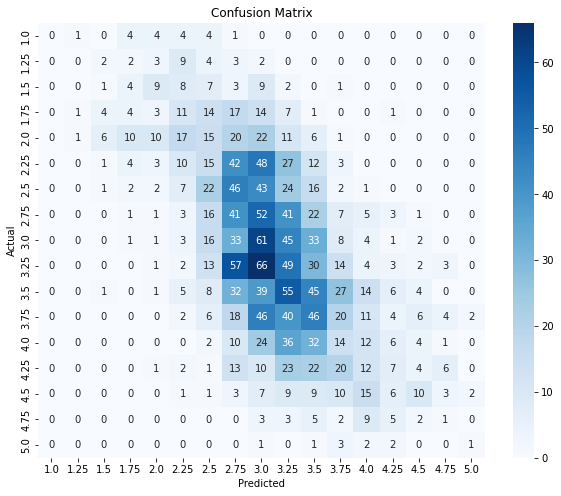

Accuracy: 0.1414


In [16]:
mse = evaluate_model(modelCNN, test_loader,conf=True)


In [17]:
print(mse)

0.46549338


In [ ]:
# Define learning rates and weight decays to search
learning_rates = [0.1, 0.01, 0.001]
weight_decays = [0.01, 0.001, 0.0001]

# Dictionary to store MSE values for each combination
mse_results = {}

# Iterate over each combination of hyperparameters
for lr in learning_rates:
    for weight_decay in weight_decays:
        # Create the model and optimizer with the current hyperparameters
        modelCNN = CNN().to(device)
        optimizer = optim.Adagrad(modelCNN.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Train the model
        train_model(modelCNN, optimizer, num_epochs=25)
        
        # Evaluate the model
        mse = evaluate_model(modelCNN, test_loader, conf=True)
        
        # Store the MSE value for the current combination of hyperparameters
        mse_results[(lr, weight_decay)] = mse

# Print the MSE values in a table
print("Learning Rate\tWeight Decay\tMSE")
for lr, weight_decay in sorted(mse_results.keys()):
    mse = mse_results[(lr, weight_decay)]
    print(f"{lr}\t\t{weight_decay}\t\t{mse}")

In [20]:
print("Learning Rate\tWeight Decay\tMSE")
for lr, weight_decay in sorted(mse_results.keys()):
    mse = mse_results[(lr, weight_decay)]
    print(f"{lr}\t\t{weight_decay}\t\t{mse}")

Learning Rate	Weight Decay	MSE
0.001		0.0001		0.4924179017543793
0.001		0.001		0.4937986135482788
0.001		0.01		0.49219805002212524
0.01		0.0001		6.2851457595825195
0.01		0.001		6.28481912612915
0.01		0.01		6.284064769744873
0.1		0.0001		6.260752201080322
0.1		0.001		3.8641197681427
0.1		0.01		3.889516592025757


c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
  2%|▏         | 1/50 [00:03<02:29,  3.05s/it]

Epoch [1/50], Loss: 1.8839
--------------------------------------------------


  4%|▍         | 2/50 [00:05<02:13,  2.79s/it]

Epoch [2/50], Loss: 0.8426
--------------------------------------------------
Epoch [3/50], Loss: 0.7016


  6%|▌         | 3/50 [00:09<02:26,  3.12s/it]

Mean Squared Error: 0.7444 and Mean Absolute Error: 0.6863
0.7443785
--------------------------------------------------
Epoch [4/50], Loss: 0.6624


  8%|▊         | 4/50 [00:12<02:30,  3.28s/it]

Mean Squared Error: 0.6834 and Mean Absolute Error: 0.6803
0.6834175
--------------------------------------------------
Epoch [5/50], Loss: 0.6272


 10%|█         | 5/50 [00:16<02:30,  3.34s/it]

Mean Squared Error: 0.6695 and Mean Absolute Error: 0.6525
0.6694984
--------------------------------------------------
Epoch [6/50], Loss: 0.5875


 12%|█▏        | 6/50 [00:19<02:28,  3.38s/it]

Mean Squared Error: 0.6246 and Mean Absolute Error: 0.6487
0.6246165
--------------------------------------------------
Epoch [7/50], Loss: 0.5591


 14%|█▍        | 7/50 [00:22<02:24,  3.35s/it]

Mean Squared Error: 0.6069 and Mean Absolute Error: 0.6276
0.60685736
--------------------------------------------------
Epoch [8/50], Loss: 0.5429


 16%|█▌        | 8/50 [00:26<02:20,  3.34s/it]

Mean Squared Error: 0.5730 and Mean Absolute Error: 0.6182
0.5730239
--------------------------------------------------
Epoch [9/50], Loss: 0.5415


 18%|█▊        | 9/50 [00:29<02:16,  3.33s/it]

Mean Squared Error: 0.5592 and Mean Absolute Error: 0.6080
0.5591545
--------------------------------------------------
Epoch [10/50], Loss: 0.5235


 20%|██        | 10/50 [00:32<02:13,  3.35s/it]

Mean Squared Error: 0.5767 and Mean Absolute Error: 0.6130
0.5766689
--------------------------------------------------
Epoch [11/50], Loss: 0.5171


 22%|██▏       | 11/50 [00:36<02:11,  3.37s/it]

Mean Squared Error: 0.5516 and Mean Absolute Error: 0.6068
0.55163044
--------------------------------------------------
Epoch [12/50], Loss: 0.5120


 24%|██▍       | 12/50 [00:39<02:07,  3.35s/it]

Mean Squared Error: 0.5375 and Mean Absolute Error: 0.5968
0.5375323
--------------------------------------------------
Epoch [13/50], Loss: 0.4987


 26%|██▌       | 13/50 [00:42<02:02,  3.32s/it]

Mean Squared Error: 0.5484 and Mean Absolute Error: 0.5963
0.5483551
--------------------------------------------------
Epoch [14/50], Loss: 0.4778


 28%|██▊       | 14/50 [00:46<01:58,  3.30s/it]

Mean Squared Error: 0.5323 and Mean Absolute Error: 0.5932
0.5323212
--------------------------------------------------
Epoch [15/50], Loss: 0.4828


 30%|███       | 15/50 [00:49<01:54,  3.28s/it]

Mean Squared Error: 0.5256 and Mean Absolute Error: 0.5871
0.525617
--------------------------------------------------
Epoch [16/50], Loss: 0.4814


 32%|███▏      | 16/50 [00:52<01:50,  3.26s/it]

Mean Squared Error: 0.5299 and Mean Absolute Error: 0.5916
0.52989656
--------------------------------------------------
Epoch [17/50], Loss: 0.4696


 34%|███▍      | 17/50 [00:55<01:47,  3.27s/it]

Mean Squared Error: 0.5228 and Mean Absolute Error: 0.5865
0.52279955
--------------------------------------------------
Epoch [18/50], Loss: 0.4705


 36%|███▌      | 18/50 [00:59<01:44,  3.27s/it]

Mean Squared Error: 0.5223 and Mean Absolute Error: 0.5878
0.52229697
--------------------------------------------------
Epoch [19/50], Loss: 0.4684


 38%|███▊      | 19/50 [01:02<01:40,  3.26s/it]

Mean Squared Error: 0.5198 and Mean Absolute Error: 0.5879
0.5197731
--------------------------------------------------
Epoch [20/50], Loss: 0.4617


 40%|████      | 20/50 [01:05<01:40,  3.37s/it]

Mean Squared Error: 0.5136 and Mean Absolute Error: 0.5826
0.51357496
--------------------------------------------------
Epoch [21/50], Loss: 0.4592


 42%|████▏     | 21/50 [01:09<01:37,  3.36s/it]

Mean Squared Error: 0.5021 and Mean Absolute Error: 0.5785
0.5021225
--------------------------------------------------
Epoch [22/50], Loss: 0.4596


 44%|████▍     | 22/50 [01:12<01:33,  3.33s/it]

Mean Squared Error: 0.5047 and Mean Absolute Error: 0.5811
0.50465935
--------------------------------------------------
Epoch [23/50], Loss: 0.4458


 46%|████▌     | 23/50 [01:15<01:29,  3.31s/it]

Mean Squared Error: 0.5122 and Mean Absolute Error: 0.5815
0.51216197
--------------------------------------------------
Epoch [24/50], Loss: 0.4558


 48%|████▊     | 24/50 [01:19<01:26,  3.33s/it]

Mean Squared Error: 0.5088 and Mean Absolute Error: 0.5808
0.50879747
--------------------------------------------------
Epoch [25/50], Loss: 0.4397


 50%|█████     | 25/50 [01:22<01:23,  3.36s/it]

Mean Squared Error: 0.5059 and Mean Absolute Error: 0.5779
0.50589454
--------------------------------------------------
Epoch [26/50], Loss: 0.4393


 52%|█████▏    | 26/50 [01:25<01:20,  3.33s/it]

Mean Squared Error: 0.5005 and Mean Absolute Error: 0.5789
0.5004664
--------------------------------------------------
Epoch [27/50], Loss: 0.4406


 54%|█████▍    | 27/50 [01:29<01:17,  3.36s/it]

Mean Squared Error: 0.5144 and Mean Absolute Error: 0.5805
0.5144484
--------------------------------------------------
Epoch [28/50], Loss: 0.4341


 56%|█████▌    | 28/50 [01:32<01:14,  3.38s/it]

Mean Squared Error: 0.4970 and Mean Absolute Error: 0.5750
0.49697173
--------------------------------------------------
Epoch [29/50], Loss: 0.4380


 58%|█████▊    | 29/50 [01:36<01:11,  3.42s/it]

Mean Squared Error: 0.4989 and Mean Absolute Error: 0.5800
0.49888727
--------------------------------------------------
Epoch [30/50], Loss: 0.4224


 60%|██████    | 30/50 [01:39<01:08,  3.41s/it]

Mean Squared Error: 0.5005 and Mean Absolute Error: 0.5725
0.5004623
--------------------------------------------------
Epoch [31/50], Loss: 0.4297


 62%|██████▏   | 31/50 [01:43<01:04,  3.39s/it]

Mean Squared Error: 0.4900 and Mean Absolute Error: 0.5731
0.49000105
--------------------------------------------------
Epoch [32/50], Loss: 0.4179


 64%|██████▍   | 32/50 [01:46<01:00,  3.36s/it]

Mean Squared Error: 0.4898 and Mean Absolute Error: 0.5708
0.48980817
--------------------------------------------------
Epoch [33/50], Loss: 0.4193


 66%|██████▌   | 33/50 [01:49<00:56,  3.35s/it]

Mean Squared Error: 0.4957 and Mean Absolute Error: 0.5738
0.49568182
--------------------------------------------------
Epoch [34/50], Loss: 0.4171


 68%|██████▊   | 34/50 [01:52<00:53,  3.35s/it]

Mean Squared Error: 0.5032 and Mean Absolute Error: 0.5765
0.503152
--------------------------------------------------
Epoch [35/50], Loss: 0.4211


 70%|███████   | 35/50 [01:56<00:50,  3.37s/it]

Mean Squared Error: 0.4865 and Mean Absolute Error: 0.5670
0.4865064
--------------------------------------------------
Epoch [36/50], Loss: 0.4113


 72%|███████▏  | 36/50 [01:59<00:47,  3.37s/it]

Mean Squared Error: 0.4797 and Mean Absolute Error: 0.5677
0.47965822
--------------------------------------------------
Epoch [37/50], Loss: 0.4157


 74%|███████▍  | 37/50 [02:03<00:43,  3.37s/it]

Mean Squared Error: 0.4833 and Mean Absolute Error: 0.5653
0.4832528
--------------------------------------------------
Epoch [38/50], Loss: 0.4107


 76%|███████▌  | 38/50 [02:06<00:40,  3.38s/it]

Mean Squared Error: 0.5006 and Mean Absolute Error: 0.5729
0.50062644
--------------------------------------------------
Epoch [39/50], Loss: 0.4082


 78%|███████▊  | 39/50 [02:09<00:37,  3.41s/it]

Mean Squared Error: 0.4900 and Mean Absolute Error: 0.5674
0.49004704
--------------------------------------------------
Epoch [40/50], Loss: 0.4111


 80%|████████  | 40/50 [02:13<00:34,  3.40s/it]

Mean Squared Error: 0.4852 and Mean Absolute Error: 0.5669
0.48520812
--------------------------------------------------
Epoch [41/50], Loss: 0.4048


 82%|████████▏ | 41/50 [02:16<00:30,  3.44s/it]

Mean Squared Error: 0.4900 and Mean Absolute Error: 0.5716
0.49002936
--------------------------------------------------
Epoch [42/50], Loss: 0.4142


 84%|████████▍ | 42/50 [02:20<00:27,  3.43s/it]

Mean Squared Error: 0.5070 and Mean Absolute Error: 0.5732
0.50699914
--------------------------------------------------
Epoch [43/50], Loss: 0.3993


 86%|████████▌ | 43/50 [02:23<00:24,  3.47s/it]

Mean Squared Error: 0.4751 and Mean Absolute Error: 0.5597
0.4750711
--------------------------------------------------
Epoch [44/50], Loss: 0.4079


 88%|████████▊ | 44/50 [02:27<00:21,  3.53s/it]

Mean Squared Error: 0.4852 and Mean Absolute Error: 0.5653
0.48517692
--------------------------------------------------
Epoch [45/50], Loss: 0.3989


 90%|█████████ | 45/50 [02:31<00:17,  3.55s/it]

Mean Squared Error: 0.4871 and Mean Absolute Error: 0.5665
0.487114
--------------------------------------------------
Epoch [46/50], Loss: 0.4018


 92%|█████████▏| 46/50 [02:34<00:14,  3.58s/it]

Mean Squared Error: 0.4988 and Mean Absolute Error: 0.5733
0.498807
--------------------------------------------------
Epoch [47/50], Loss: 0.3939


 94%|█████████▍| 47/50 [02:38<00:10,  3.61s/it]

Mean Squared Error: 0.4847 and Mean Absolute Error: 0.5703
0.48468775
--------------------------------------------------
Epoch [48/50], Loss: 0.3954


 96%|█████████▌| 48/50 [02:42<00:07,  3.60s/it]

Mean Squared Error: 0.4780 and Mean Absolute Error: 0.5661
0.47799757
--------------------------------------------------
Epoch [49/50], Loss: 0.3849


 98%|█████████▊| 49/50 [02:45<00:03,  3.54s/it]

Mean Squared Error: 0.4857 and Mean Absolute Error: 0.5643
0.48567
--------------------------------------------------
Epoch [50/50], Loss: 0.3897


100%|██████████| 50/50 [02:48<00:00,  3.38s/it]

Mean Squared Error: 0.4824 and Mean Absolute Error: 0.5653
0.48243657
--------------------------------------------------


Mean Squared Error: 0.3828 and Mean Absolute Error: 0.4973


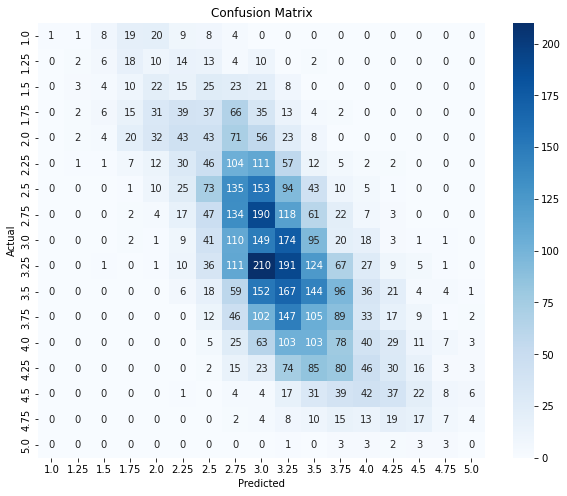

Accuracy: 0.1545
0.38275102
Mean Squared Error: 0.4732 and Mean Absolute Error: 0.5543


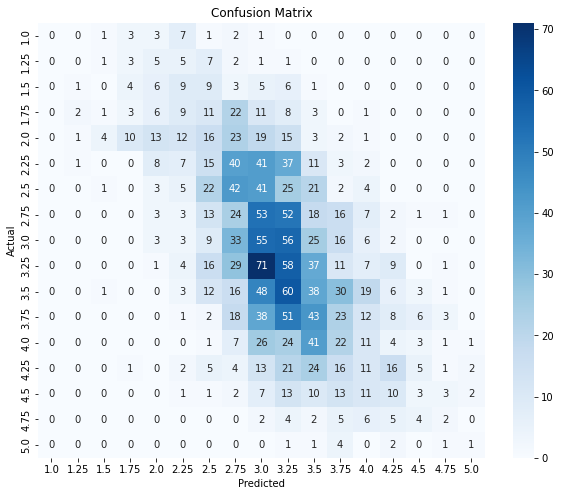

c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Accuracy: 0.1328


  2%|▏         | 1/50 [00:02<02:10,  2.66s/it]

Epoch [1/50], Loss: 1.8834
--------------------------------------------------


  4%|▍         | 2/50 [00:05<02:06,  2.65s/it]

Epoch [2/50], Loss: 0.8421
--------------------------------------------------
Epoch [3/50], Loss: 0.7032


  6%|▌         | 3/50 [00:08<02:19,  2.98s/it]

Mean Squared Error: 0.7488 and Mean Absolute Error: 0.6880
0.74884766
--------------------------------------------------
Epoch [4/50], Loss: 0.6637


  8%|▊         | 4/50 [00:12<02:24,  3.15s/it]

Mean Squared Error: 0.6818 and Mean Absolute Error: 0.6787
0.68181276
--------------------------------------------------
Epoch [5/50], Loss: 0.6260


 10%|█         | 5/50 [00:15<02:25,  3.23s/it]

Mean Squared Error: 0.6640 and Mean Absolute Error: 0.6496
0.663951
--------------------------------------------------
Epoch [6/50], Loss: 0.5882


 12%|█▏        | 6/50 [00:18<02:24,  3.28s/it]

Mean Squared Error: 0.6202 and Mean Absolute Error: 0.6451
0.6202105
--------------------------------------------------
Epoch [7/50], Loss: 0.5582


 14%|█▍        | 7/50 [00:22<02:22,  3.31s/it]

Mean Squared Error: 0.6088 and Mean Absolute Error: 0.6292
0.6088277
--------------------------------------------------
Epoch [8/50], Loss: 0.5406


 16%|█▌        | 8/50 [00:25<02:20,  3.34s/it]

Mean Squared Error: 0.5776 and Mean Absolute Error: 0.6204
0.57764685
--------------------------------------------------
Epoch [9/50], Loss: 0.5406


 18%|█▊        | 9/50 [00:28<02:17,  3.35s/it]

Mean Squared Error: 0.5586 and Mean Absolute Error: 0.6069
0.55861574
--------------------------------------------------
Epoch [10/50], Loss: 0.5241


 20%|██        | 10/50 [00:32<02:14,  3.36s/it]

Mean Squared Error: 0.5704 and Mean Absolute Error: 0.6098
0.570429
--------------------------------------------------
Epoch [11/50], Loss: 0.5169


 22%|██▏       | 11/50 [00:35<02:11,  3.38s/it]

Mean Squared Error: 0.5537 and Mean Absolute Error: 0.6082
0.55369
--------------------------------------------------
Epoch [12/50], Loss: 0.5095


 24%|██▍       | 12/50 [00:39<02:08,  3.39s/it]

Mean Squared Error: 0.5388 and Mean Absolute Error: 0.5958
0.5387689
--------------------------------------------------
Epoch [13/50], Loss: 0.5002


 26%|██▌       | 13/50 [00:42<02:06,  3.42s/it]

Mean Squared Error: 0.5421 and Mean Absolute Error: 0.5931
0.5421396
--------------------------------------------------
Epoch [14/50], Loss: 0.4768


 28%|██▊       | 14/50 [00:46<02:03,  3.42s/it]

Mean Squared Error: 0.5351 and Mean Absolute Error: 0.5958
0.53505266
--------------------------------------------------
Epoch [15/50], Loss: 0.4814


 30%|███       | 15/50 [00:49<01:59,  3.42s/it]

Mean Squared Error: 0.5232 and Mean Absolute Error: 0.5846
0.5232051
--------------------------------------------------
Epoch [16/50], Loss: 0.4822


 32%|███▏      | 16/50 [00:52<01:56,  3.41s/it]

Mean Squared Error: 0.5285 and Mean Absolute Error: 0.5905
0.5285331
--------------------------------------------------
Epoch [17/50], Loss: 0.4685


 34%|███▍      | 17/50 [00:56<01:52,  3.41s/it]

Mean Squared Error: 0.5206 and Mean Absolute Error: 0.5850
0.5206104
--------------------------------------------------
Epoch [18/50], Loss: 0.4727


 36%|███▌      | 18/50 [00:59<01:49,  3.42s/it]

Mean Squared Error: 0.5210 and Mean Absolute Error: 0.5875
0.5210284
--------------------------------------------------
Epoch [19/50], Loss: 0.4674


 38%|███▊      | 19/50 [01:03<01:46,  3.42s/it]

Mean Squared Error: 0.5226 and Mean Absolute Error: 0.5884
0.52261555
--------------------------------------------------
Epoch [20/50], Loss: 0.4646


 40%|████      | 20/50 [01:06<01:42,  3.42s/it]

Mean Squared Error: 0.5107 and Mean Absolute Error: 0.5807
0.51068854
--------------------------------------------------
Epoch [21/50], Loss: 0.4581


 42%|████▏     | 21/50 [01:10<01:39,  3.42s/it]

Mean Squared Error: 0.5046 and Mean Absolute Error: 0.5798
0.50459874
--------------------------------------------------
Epoch [22/50], Loss: 0.4587


 44%|████▍     | 22/50 [01:13<01:36,  3.46s/it]

Mean Squared Error: 0.5028 and Mean Absolute Error: 0.5801
0.50281256
--------------------------------------------------
Epoch [23/50], Loss: 0.4469


 46%|████▌     | 23/50 [01:17<01:35,  3.54s/it]

Mean Squared Error: 0.5116 and Mean Absolute Error: 0.5815
0.5115899
--------------------------------------------------
Epoch [24/50], Loss: 0.4553


 48%|████▊     | 24/50 [01:20<01:32,  3.56s/it]

Mean Squared Error: 0.5066 and Mean Absolute Error: 0.5803
0.5065588
--------------------------------------------------
Epoch [25/50], Loss: 0.4385


 50%|█████     | 25/50 [01:24<01:28,  3.54s/it]

Mean Squared Error: 0.5038 and Mean Absolute Error: 0.5760
0.50375164
--------------------------------------------------
Epoch [26/50], Loss: 0.4373


 52%|█████▏    | 26/50 [01:27<01:24,  3.53s/it]

Mean Squared Error: 0.5016 and Mean Absolute Error: 0.5779
0.50157726
--------------------------------------------------
Epoch [27/50], Loss: 0.4407


 54%|█████▍    | 27/50 [01:31<01:21,  3.52s/it]

Mean Squared Error: 0.5110 and Mean Absolute Error: 0.5798
0.51095873
--------------------------------------------------
Epoch [28/50], Loss: 0.4317


 56%|█████▌    | 28/50 [01:35<01:18,  3.56s/it]

Mean Squared Error: 0.4926 and Mean Absolute Error: 0.5728
0.49262175
--------------------------------------------------
Epoch [29/50], Loss: 0.4341


 58%|█████▊    | 29/50 [01:38<01:14,  3.55s/it]

Mean Squared Error: 0.4946 and Mean Absolute Error: 0.5762
0.49460307
--------------------------------------------------
Epoch [30/50], Loss: 0.4223


 60%|██████    | 30/50 [01:42<01:11,  3.55s/it]

Mean Squared Error: 0.5014 and Mean Absolute Error: 0.5733
0.50138956
--------------------------------------------------
Epoch [31/50], Loss: 0.4273


 62%|██████▏   | 31/50 [01:45<01:07,  3.55s/it]

Mean Squared Error: 0.4898 and Mean Absolute Error: 0.5722
0.48975086
--------------------------------------------------
Epoch [32/50], Loss: 0.4186


 64%|██████▍   | 32/50 [01:49<01:03,  3.53s/it]

Mean Squared Error: 0.4928 and Mean Absolute Error: 0.5725
0.49278304
--------------------------------------------------
Epoch [33/50], Loss: 0.4187


 66%|██████▌   | 33/50 [01:52<01:00,  3.53s/it]

Mean Squared Error: 0.4941 and Mean Absolute Error: 0.5736
0.4941254
--------------------------------------------------
Epoch [34/50], Loss: 0.4152


 68%|██████▊   | 34/50 [01:56<00:56,  3.55s/it]

Mean Squared Error: 0.4983 and Mean Absolute Error: 0.5741
0.4982822
--------------------------------------------------
Epoch [35/50], Loss: 0.4192


 70%|███████   | 35/50 [01:59<00:53,  3.54s/it]

Mean Squared Error: 0.4833 and Mean Absolute Error: 0.5657
0.4833019
--------------------------------------------------
Epoch [36/50], Loss: 0.4128


 72%|███████▏  | 36/50 [02:03<00:49,  3.53s/it]

Mean Squared Error: 0.4783 and Mean Absolute Error: 0.5667
0.47833517
--------------------------------------------------
Epoch [37/50], Loss: 0.4130


 74%|███████▍  | 37/50 [02:06<00:45,  3.51s/it]

Mean Squared Error: 0.4837 and Mean Absolute Error: 0.5640
0.4836782
--------------------------------------------------
Epoch [38/50], Loss: 0.4107


 76%|███████▌  | 38/50 [02:10<00:42,  3.52s/it]

Mean Squared Error: 0.4987 and Mean Absolute Error: 0.5722
0.4987006
--------------------------------------------------
Epoch [39/50], Loss: 0.4071


 78%|███████▊  | 39/50 [02:13<00:38,  3.50s/it]

Mean Squared Error: 0.4856 and Mean Absolute Error: 0.5645
0.4856093
--------------------------------------------------
Epoch [40/50], Loss: 0.4079


 80%|████████  | 40/50 [02:17<00:34,  3.48s/it]

Mean Squared Error: 0.4829 and Mean Absolute Error: 0.5660
0.4829377
--------------------------------------------------
Epoch [41/50], Loss: 0.4030


 82%|████████▏ | 41/50 [02:20<00:31,  3.48s/it]

Mean Squared Error: 0.4889 and Mean Absolute Error: 0.5705
0.48889014
--------------------------------------------------
Epoch [42/50], Loss: 0.4119


 84%|████████▍ | 42/50 [02:24<00:27,  3.48s/it]

Mean Squared Error: 0.5039 and Mean Absolute Error: 0.5702
0.50388825
--------------------------------------------------
Epoch [43/50], Loss: 0.3969


 86%|████████▌ | 43/50 [02:27<00:24,  3.50s/it]

Mean Squared Error: 0.4750 and Mean Absolute Error: 0.5576
0.47502136
--------------------------------------------------
Epoch [44/50], Loss: 0.4050


 88%|████████▊ | 44/50 [02:31<00:21,  3.62s/it]

Mean Squared Error: 0.4855 and Mean Absolute Error: 0.5660
0.48547205
--------------------------------------------------
Epoch [45/50], Loss: 0.3975


 90%|█████████ | 45/50 [02:35<00:18,  3.66s/it]

Mean Squared Error: 0.4864 and Mean Absolute Error: 0.5663
0.48640937
--------------------------------------------------
Epoch [46/50], Loss: 0.3989


 92%|█████████▏| 46/50 [02:39<00:14,  3.74s/it]

Mean Squared Error: 0.4909 and Mean Absolute Error: 0.5702
0.49085996
--------------------------------------------------
Epoch [47/50], Loss: 0.3912


 94%|█████████▍| 47/50 [02:42<00:11,  3.70s/it]

Mean Squared Error: 0.4787 and Mean Absolute Error: 0.5688
0.47872624
--------------------------------------------------
Epoch [48/50], Loss: 0.3923


 96%|█████████▌| 48/50 [02:46<00:07,  3.56s/it]

Mean Squared Error: 0.4761 and Mean Absolute Error: 0.5644
0.47606358
--------------------------------------------------
Epoch [49/50], Loss: 0.3818


 98%|█████████▊| 49/50 [02:49<00:03,  3.58s/it]

Mean Squared Error: 0.4819 and Mean Absolute Error: 0.5619
0.48192284
--------------------------------------------------
Epoch [50/50], Loss: 0.3855


100%|██████████| 50/50 [02:53<00:00,  3.47s/it]

Mean Squared Error: 0.4830 and Mean Absolute Error: 0.5647
0.48302835
--------------------------------------------------


Mean Squared Error: 0.3812 and Mean Absolute Error: 0.4962


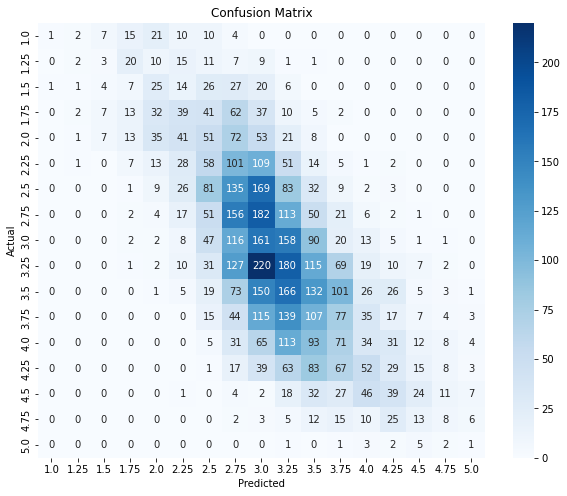

Accuracy: 0.1550
0.3812104
Mean Squared Error: 0.4694 and Mean Absolute Error: 0.5527


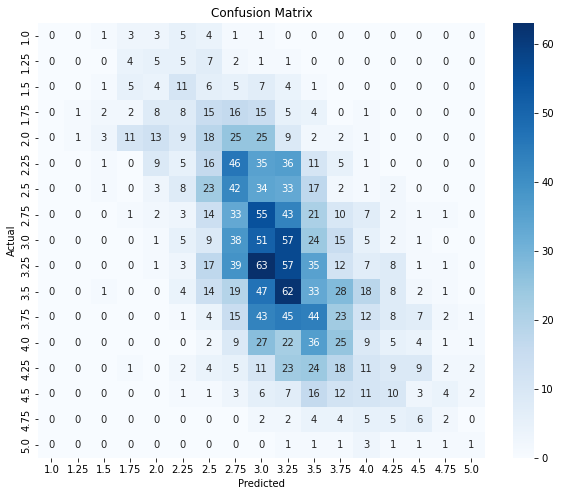

c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Accuracy: 0.1275


  2%|▏         | 1/50 [00:02<02:11,  2.68s/it]

Epoch [1/50], Loss: 1.8833
--------------------------------------------------


  4%|▍         | 2/50 [00:05<02:10,  2.71s/it]

Epoch [2/50], Loss: 0.8412
--------------------------------------------------
Epoch [3/50], Loss: 0.7017


  6%|▌         | 3/50 [00:08<02:23,  3.06s/it]

Mean Squared Error: 0.7465 and Mean Absolute Error: 0.6870
0.74654454
--------------------------------------------------
Epoch [4/50], Loss: 0.6632


  8%|▊         | 4/50 [00:12<02:28,  3.22s/it]

Mean Squared Error: 0.6806 and Mean Absolute Error: 0.6780
0.68063176
--------------------------------------------------
Epoch [5/50], Loss: 0.6257


 10%|█         | 5/50 [00:15<02:30,  3.34s/it]

Mean Squared Error: 0.6625 and Mean Absolute Error: 0.6494
0.66252464
--------------------------------------------------
Epoch [6/50], Loss: 0.5880


 12%|█▏        | 6/50 [00:19<02:29,  3.40s/it]

Mean Squared Error: 0.6203 and Mean Absolute Error: 0.6453
0.6202665
--------------------------------------------------
Epoch [7/50], Loss: 0.5576


 14%|█▍        | 7/50 [00:22<02:26,  3.42s/it]

Mean Squared Error: 0.6082 and Mean Absolute Error: 0.6289
0.6081703
--------------------------------------------------
Epoch [8/50], Loss: 0.5398


 16%|█▌        | 8/50 [00:26<02:24,  3.44s/it]

Mean Squared Error: 0.5775 and Mean Absolute Error: 0.6204
0.5774549
--------------------------------------------------
Epoch [9/50], Loss: 0.5396


 18%|█▊        | 9/50 [00:29<02:22,  3.47s/it]

Mean Squared Error: 0.5574 and Mean Absolute Error: 0.6062
0.5574188
--------------------------------------------------
Epoch [10/50], Loss: 0.5230


 20%|██        | 10/50 [00:33<02:19,  3.48s/it]

Mean Squared Error: 0.5686 and Mean Absolute Error: 0.6093
0.56855184
--------------------------------------------------
Epoch [11/50], Loss: 0.5156


 22%|██▏       | 11/50 [00:36<02:15,  3.49s/it]

Mean Squared Error: 0.5541 and Mean Absolute Error: 0.6087
0.55409265
--------------------------------------------------
Epoch [12/50], Loss: 0.5077


 24%|██▍       | 12/50 [00:40<02:12,  3.48s/it]

Mean Squared Error: 0.5399 and Mean Absolute Error: 0.5965
0.539857
--------------------------------------------------
Epoch [13/50], Loss: 0.4986


 26%|██▌       | 13/50 [00:43<02:09,  3.49s/it]

Mean Squared Error: 0.5404 and Mean Absolute Error: 0.5924
0.54036546
--------------------------------------------------
Epoch [14/50], Loss: 0.4751


 28%|██▊       | 14/50 [00:47<02:06,  3.50s/it]

Mean Squared Error: 0.5341 and Mean Absolute Error: 0.5954
0.5341497
--------------------------------------------------
Epoch [15/50], Loss: 0.4791


 30%|███       | 15/50 [00:50<02:02,  3.50s/it]

Mean Squared Error: 0.5236 and Mean Absolute Error: 0.5842
0.52361035
--------------------------------------------------
Epoch [16/50], Loss: 0.4807


 32%|███▏      | 16/50 [00:54<02:00,  3.53s/it]

Mean Squared Error: 0.5289 and Mean Absolute Error: 0.5902
0.5288797
--------------------------------------------------
Epoch [17/50], Loss: 0.4655


 34%|███▍      | 17/50 [00:58<01:56,  3.52s/it]

Mean Squared Error: 0.5214 and Mean Absolute Error: 0.5859
0.52141637
--------------------------------------------------
Epoch [18/50], Loss: 0.4717


 36%|███▌      | 18/50 [01:01<01:52,  3.52s/it]

Mean Squared Error: 0.5203 and Mean Absolute Error: 0.5864
0.5202706
--------------------------------------------------
Epoch [19/50], Loss: 0.4654


 38%|███▊      | 19/50 [01:05<01:49,  3.53s/it]

Mean Squared Error: 0.5278 and Mean Absolute Error: 0.5910
0.5278255
--------------------------------------------------
Epoch [20/50], Loss: 0.4606


 40%|████      | 20/50 [01:08<01:45,  3.51s/it]

Mean Squared Error: 0.5063 and Mean Absolute Error: 0.5785
0.5062895
--------------------------------------------------
Epoch [21/50], Loss: 0.4566


 42%|████▏     | 21/50 [01:12<01:42,  3.52s/it]

Mean Squared Error: 0.5039 and Mean Absolute Error: 0.5794
0.5039281
--------------------------------------------------
Epoch [22/50], Loss: 0.4539


 44%|████▍     | 22/50 [01:15<01:38,  3.52s/it]

Mean Squared Error: 0.5042 and Mean Absolute Error: 0.5805
0.50418836
--------------------------------------------------
Epoch [23/50], Loss: 0.4461


 46%|████▌     | 23/50 [01:19<01:34,  3.51s/it]

Mean Squared Error: 0.5089 and Mean Absolute Error: 0.5795
0.50886166
--------------------------------------------------
Epoch [24/50], Loss: 0.4525


 48%|████▊     | 24/50 [01:22<01:31,  3.52s/it]

Mean Squared Error: 0.5096 and Mean Absolute Error: 0.5821
0.509589
--------------------------------------------------
Epoch [25/50], Loss: 0.4385


 50%|█████     | 25/50 [01:26<01:27,  3.51s/it]

Mean Squared Error: 0.5025 and Mean Absolute Error: 0.5759
0.5024754
--------------------------------------------------
Epoch [26/50], Loss: 0.4363


 52%|█████▏    | 26/50 [01:29<01:24,  3.50s/it]

Mean Squared Error: 0.5075 and Mean Absolute Error: 0.5821
0.5074668
--------------------------------------------------
Epoch [27/50], Loss: 0.4390


 54%|█████▍    | 27/50 [01:33<01:20,  3.51s/it]

Mean Squared Error: 0.5086 and Mean Absolute Error: 0.5789
0.5086077
--------------------------------------------------
Epoch [28/50], Loss: 0.4328


 56%|█████▌    | 28/50 [01:36<01:17,  3.53s/it]

Mean Squared Error: 0.4980 and Mean Absolute Error: 0.5763
0.49801785
--------------------------------------------------
Epoch [29/50], Loss: 0.4338


 58%|█████▊    | 29/50 [01:40<01:13,  3.52s/it]

Mean Squared Error: 0.4968 and Mean Absolute Error: 0.5764
0.49680197
--------------------------------------------------
Epoch [30/50], Loss: 0.4232


 60%|██████    | 30/50 [01:43<01:10,  3.51s/it]

Mean Squared Error: 0.5043 and Mean Absolute Error: 0.5744
0.50426835
--------------------------------------------------
Epoch [31/50], Loss: 0.4247


 62%|██████▏   | 31/50 [01:47<01:06,  3.52s/it]

Mean Squared Error: 0.4888 and Mean Absolute Error: 0.5715
0.48882145
--------------------------------------------------
Epoch [32/50], Loss: 0.4203


 64%|██████▍   | 32/50 [01:50<01:03,  3.52s/it]

Mean Squared Error: 0.4940 and Mean Absolute Error: 0.5737
0.49403566
--------------------------------------------------
Epoch [33/50], Loss: 0.4152


 66%|██████▌   | 33/50 [01:54<00:59,  3.51s/it]

Mean Squared Error: 0.5014 and Mean Absolute Error: 0.5754
0.5013628
--------------------------------------------------
Epoch [34/50], Loss: 0.4162


 68%|██████▊   | 34/50 [01:57<00:56,  3.51s/it]

Mean Squared Error: 0.4976 and Mean Absolute Error: 0.5741
0.49763826
--------------------------------------------------
Epoch [35/50], Loss: 0.4149


 70%|███████   | 35/50 [02:01<00:52,  3.51s/it]

Mean Squared Error: 0.4848 and Mean Absolute Error: 0.5680
0.48481083
--------------------------------------------------
Epoch [36/50], Loss: 0.4137


 72%|███████▏  | 36/50 [02:04<00:49,  3.50s/it]

Mean Squared Error: 0.4779 and Mean Absolute Error: 0.5663
0.4778532
--------------------------------------------------
Epoch [37/50], Loss: 0.4096


 74%|███████▍  | 37/50 [02:08<00:46,  3.55s/it]

Mean Squared Error: 0.4914 and Mean Absolute Error: 0.5681
0.49135587
--------------------------------------------------
Epoch [38/50], Loss: 0.4104


 76%|███████▌  | 38/50 [02:12<00:43,  3.63s/it]

Mean Squared Error: 0.4966 and Mean Absolute Error: 0.5718
0.49664277
--------------------------------------------------
Epoch [39/50], Loss: 0.4043


 78%|███████▊  | 39/50 [02:15<00:39,  3.61s/it]

Mean Squared Error: 0.4883 and Mean Absolute Error: 0.5675
0.48834017
--------------------------------------------------
Epoch [40/50], Loss: 0.4070


 80%|████████  | 40/50 [02:19<00:35,  3.59s/it]

Mean Squared Error: 0.4803 and Mean Absolute Error: 0.5649
0.48028058
--------------------------------------------------
Epoch [41/50], Loss: 0.4008


 82%|████████▏ | 41/50 [02:22<00:32,  3.58s/it]

Mean Squared Error: 0.4970 and Mean Absolute Error: 0.5759
0.4969981
--------------------------------------------------
Epoch [42/50], Loss: 0.4101


 84%|████████▍ | 42/50 [02:26<00:28,  3.56s/it]

Mean Squared Error: 0.4933 and Mean Absolute Error: 0.5664
0.49332738
--------------------------------------------------
Epoch [43/50], Loss: 0.3958


 86%|████████▌ | 43/50 [02:30<00:25,  3.57s/it]

Mean Squared Error: 0.4762 and Mean Absolute Error: 0.5594
0.4762312
--------------------------------------------------
Epoch [44/50], Loss: 0.4024


 88%|████████▊ | 44/50 [02:33<00:21,  3.62s/it]

Mean Squared Error: 0.4858 and Mean Absolute Error: 0.5655
0.485766
--------------------------------------------------
Epoch [45/50], Loss: 0.3981


 90%|█████████ | 45/50 [02:37<00:17,  3.59s/it]

Mean Squared Error: 0.4976 and Mean Absolute Error: 0.5718
0.49762145
--------------------------------------------------
Epoch [46/50], Loss: 0.3952


 92%|█████████▏| 46/50 [02:40<00:14,  3.55s/it]

Mean Squared Error: 0.4829 and Mean Absolute Error: 0.5667
0.48287833
--------------------------------------------------
Epoch [47/50], Loss: 0.3935


 94%|█████████▍| 47/50 [02:44<00:10,  3.52s/it]

Mean Squared Error: 0.4825 and Mean Absolute Error: 0.5703
0.48247987
--------------------------------------------------
Epoch [48/50], Loss: 0.3876


 96%|█████████▌| 48/50 [02:47<00:07,  3.50s/it]

Mean Squared Error: 0.4793 and Mean Absolute Error: 0.5639
0.4792507
--------------------------------------------------
Epoch [49/50], Loss: 0.3842


 98%|█████████▊| 49/50 [02:51<00:03,  3.50s/it]

Mean Squared Error: 0.4880 and Mean Absolute Error: 0.5652
0.48802555
--------------------------------------------------
Epoch [50/50], Loss: 0.3817


100%|██████████| 50/50 [02:54<00:00,  3.49s/it]

Mean Squared Error: 0.4774 and Mean Absolute Error: 0.5618
0.477418
--------------------------------------------------


Mean Squared Error: 0.3800 and Mean Absolute Error: 0.4958


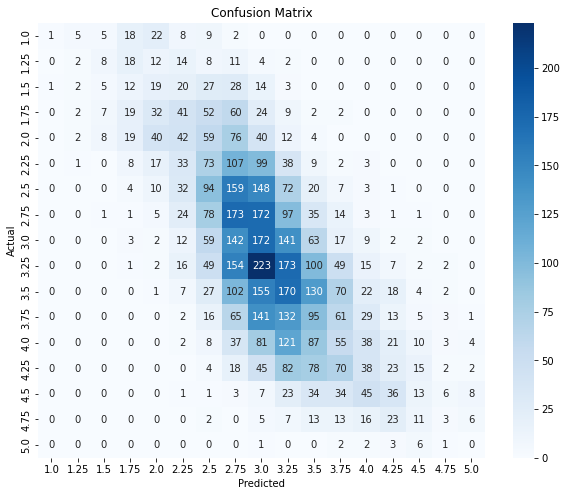

Accuracy: 0.1572
0.37998852
Mean Squared Error: 0.4631 and Mean Absolute Error: 0.5508


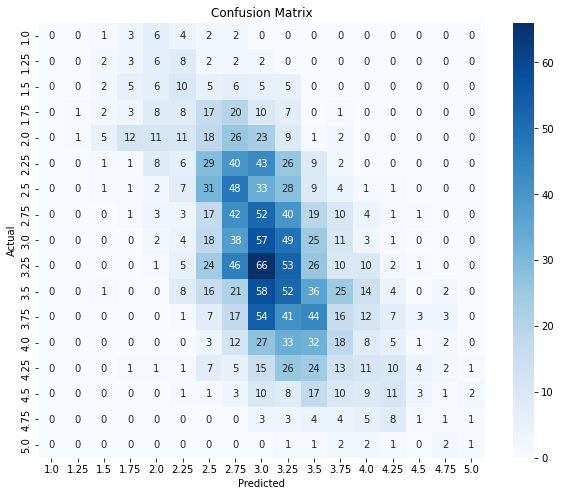

Accuracy: 0.1347
Learning Rate	Weight Decay	MSE
0.001		0.0001		0.4631446599960327
0.001		0.001		0.4694153666496277
0.001		0.01		0.47323518991470337


In [22]:
# Define learning rates and weight decays to search
learning_rates = [0.001]
weight_decays = [0.01, 0.001, 0.0001]

# Dictionary to store MSE values for each combination
mse_results = {}

# Iterate over each combination of hyperparameters
for lr in learning_rates:
    for weight_decay in weight_decays:
        # Create the model and optimizer with the current hyperparameters
        modelCNN = CNN().to(device)
        optimizer = optim.Adagrad(modelCNN.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Train the model
        train_model(modelCNN, optimizer, num_epochs=50)
        
        # Evaluate the model
        mse = evaluate_model(modelCNN, test_loader, conf=True)
        
        # Store the MSE value for the current combination of hyperparameters
        mse_results[(lr, weight_decay)] = mse

# Print the MSE values in a table
print("Learning Rate\tWeight Decay\tMSE")
for lr, weight_decay in sorted(mse_results.keys()):
    mse = mse_results[(lr, weight_decay)]
    print(f"{lr}\t\t{weight_decay}\t\t{mse}")